# Trying out an LSTM setup
## Using generated data
### Bi-directional LSTM with adversarial softmax layer

### Generate data

In [2]:
from experts import Expert, mountain_car
expert = Expert('MountainCar-v0')
NUMBER_OF_EPISODES = 100
data, avg_reward = expert.generate_data(NUMBER_OF_EPISODES)
avg_reward

-104.51

In [3]:
data.shape

(10451, 4)

### Plot expert data

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/home/brendanjcrowe/anaconda3/envs/seq/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


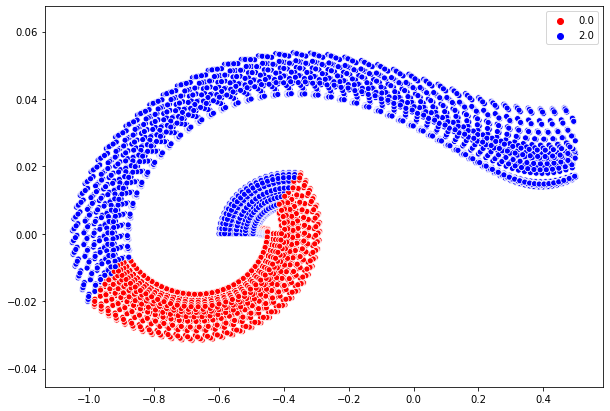

In [5]:
colors = np.array(['red', 'green', 'blue'])
palette = colors[np.unique(data[:,2]).astype(int)].tolist()

fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=data[:,2], palette=palette)

### Preprocess data into sequences

In [6]:
X_partitioned = np.empty((100,), dtype=object)
max_len = 0
for i in range(NUMBER_OF_EPISODES):
    
    seq = []
    length = 0
    for j in range(len(data)):
        
        if data[j][3] == i: 
            
            seq.append([x for x in data[j]])
            length +=1
    
    X_partitioned[i] = np.array(seq)
    if length > max_len: max_len = length
        
max_len

146

In [7]:
import torch

In [8]:
def seq_to_x(seq, pad_to):
    
    return [
            [seq[i][0], seq[i][1], int(i==0), int(i==len(seq)-1), 0] if i < len(seq)
            else [0, 0, 0, 0, 1]
            for i in range(pad_to)
        ]

def seq_to_target(seq, pad_to):
    
    return [
            seq[i][2] if i < len(seq) else 1 for i in range(pad_to)
        ]


def training_X(data, max_len):
    
    return torch.tensor(
        np.array(
            [
                seq_to_x(seq, max_len) for seq in data
            ],
            dtype=np.float
        ),
        dtype=torch.float
    )

def training_Y(data, max_len):
    
    return torch.tensor(
        [
            seq_to_target(seq, max_len) for seq in data
        ],
        dtype=torch.long
    )

def true_indicies(Y):
    
    true = []
    for i in range(Y.shape[0]):
        
        if Y[i] == 0 or Y[i] == 2:
            true.append(i)
    
    return true

In [9]:
X = training_X(X_partitioned, max_len)
X.view(-1, 2).shape

torch.Size([36500, 2])

In [10]:
Y = torch.unsqueeze(training_Y(X_partitioned, max_len), dim=2)
true = true_indicies(Y.view(-1))


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PolicyLSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, target_size):
        
        super(PolicyLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, bias=True, batch_first=True, bidirectional=True)
        
        self.linear = nn.Linear(hidden_dim*2, target_size)
        
        self.output = nn.LogSoftmax(dim=2)
        
    def forward(self, batch):
        
        lstm_out, _ = self.lstm(batch)
        #print(lstm_out.shape)
        linear_out = self.linear(lstm_out)
        #print(linear_out.shape)
        out = self.output(linear_out)
        #print(out.shape)
        return out
    
    def predict(self, X):
        
        with torch.no_grad():
            pred = self.forward(X)
        
        return torch.argmax(pred, dim=2).view(-1)

model = PolicyLSTM(5, 10, 3)

In [12]:
x = torch.randn(100, 160, 3)
x.view(-1, 3).shape

torch.Size([16000, 3])

In [27]:
def train(xdata, ydata, model):
    '''Train the neural model with the given training data'''

    criterion = torch.nn.NLLLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 


    for epoch in range(2000):
        
        model.zero_grad()
        
        Y_pred = model(xdata)
        
        #print(ydata[99])
        loss = criterion(Y_pred.view(-1, 3), ydata.view(-1))
        
        if epoch % 100 == 0: print('epoch: ', epoch,' loss: ', loss.item()) 

        loss.backward()

        optimizer.step()
        
    return model

In [33]:
train(X, Y, model)

epoch:  0  loss:  0.19942913949489594
epoch:  100  loss:  0.19545654952526093
epoch:  200  loss:  0.1919761300086975
epoch:  300  loss:  0.18894445896148682
epoch:  400  loss:  0.18616478145122528
epoch:  500  loss:  0.20830583572387695
epoch:  600  loss:  0.37487488985061646
epoch:  700  loss:  0.17193618416786194
epoch:  800  loss:  0.2577775716781616
epoch:  900  loss:  0.1675490289926529
epoch:  1000  loss:  0.1648987978696823
epoch:  1100  loss:  0.16431924700737
epoch:  1200  loss:  0.16055472195148468
epoch:  1300  loss:  0.15853771567344666
epoch:  1400  loss:  0.15911823511123657
epoch:  1500  loss:  0.15482410788536072
epoch:  1600  loss:  0.15194404125213623
epoch:  1700  loss:  0.1502365618944168
epoch:  1800  loss:  0.17692042887210846
epoch:  1900  loss:  0.1451040506362915


PolicyLSTM(
  (lstm): LSTM(5, 10, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=20, out_features=3, bias=True)
  (output): LogSoftmax(dim=2)
)

In [34]:
preds = model.predict(X)[true]
preds

tensor([0, 0, 0,  ..., 2, 2, 2])

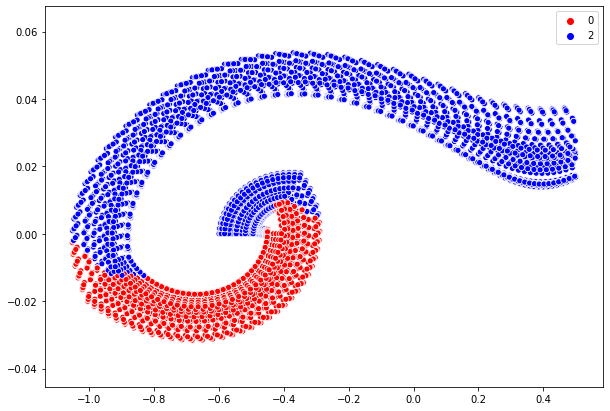

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=preds, palette=['red',  'blue'])